# Mini-TP (20 min) — Filtres de Gabor sur l’image de Lena

**Public :** M1 Ingénierie • **Objectif :** visualiser l’effet des filtres de Gabor (orientation & fréquence spatiale) pour détecter des textures et motifs orientés.


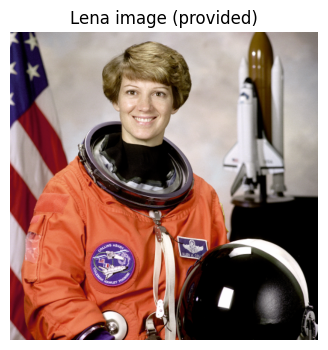

In [1]:
# === Setup: imports & image ===
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

img_path = 'lena_demo.png'
if not os.path.exists(img_path):
    raise FileNotFoundError("Place 'lena_demo.png' in the working directory.")
img_rgb = np.array(Image.open(img_path))
img_gray = np.dot(img_rgb[...,:3], [0.299, 0.587, 0.114]) / 255.0

plt.figure(figsize=(5,4))
plt.imshow(img_rgb)
plt.title("Lena image (provided)")
plt.axis('off')
plt.show()


In [2]:
# === Generate Gabor kernel ===
def gabor_kernel(ksize=31, sigma=6.0, theta=np.pi/4, lam=10.0, gamma=0.5, phi=0.0):
    import numpy as np
    assert ksize % 2 == 1
    half = ksize // 2
    y, x = np.meshgrid(np.arange(-half, half+1), np.arange(-half, half+1), indexing='xy')
    x_p =  x*np.cos(theta) + y*np.sin(theta)
    y_p = -x*np.sin(theta) + y*np.cos(theta)
    gauss = np.exp(-(x_p**2 + (gamma**2)*(y_p**2)) / (2*sigma**2))
    sinus = np.cos(2*np.pi * x_p/lam + phi)
    g = gauss * sinus
    g -= g.mean()
    s = np.sqrt((g**2).sum())
    if s > 1e-8:
        g /= s
    return g


In [3]:
# === Simple 2D convolution ===
def conv2_valid(img, kernel):
    H, W = img.shape
    k = kernel.shape[0]
    out_h = H - k + 1
    out_w = W - k + 1
    out = np.zeros((out_h, out_w), dtype=np.float32)
    kr = kernel[::-1, ::-1]
    for i in range(out_h):
        for j in range(out_w):
            out[i, j] = np.sum(img[i:i+k, j:j+k] * kr)
    return out

def conv2_same(img, kernel):
    k = kernel.shape[0]
    pad = k//2
    img_p = np.pad(img, ((pad,pad),(pad,pad)), mode='reflect')
    return conv2_valid(img_p, kernel)


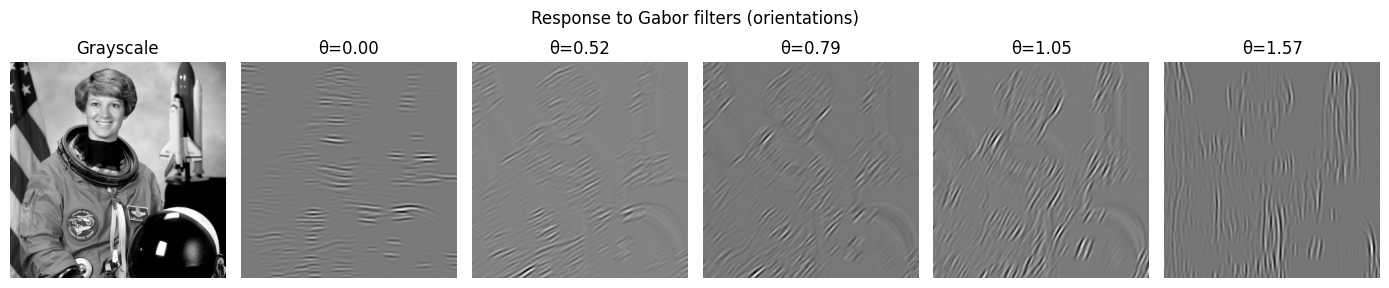

In [4]:
# === Orientation demo ===
thetas = [0, np.pi/6, np.pi/4, np.pi/3, np.pi/2]
k = 31
lam = 10.0
gamma = 0.5
sigma = 6.0

fig, axes = plt.subplots(1, len(thetas)+1, figsize=(14,3))
axes[0].imshow(img_gray, cmap='gray'); axes[0].set_title("Grayscale"); axes[0].axis('off')

for idx, th in enumerate(thetas, start=1):
    g = gabor_kernel(ksize=k, sigma=sigma, theta=th, lam=lam, gamma=gamma, phi=0.0)
    resp = conv2_same(img_gray, g)
    axes[idx].imshow(resp, cmap='gray')
    axes[idx].set_title(f"θ={th:.2f}")
    axes[idx].axis('off')

plt.suptitle("Response to Gabor filters (orientations)")
plt.tight_layout()
plt.show()


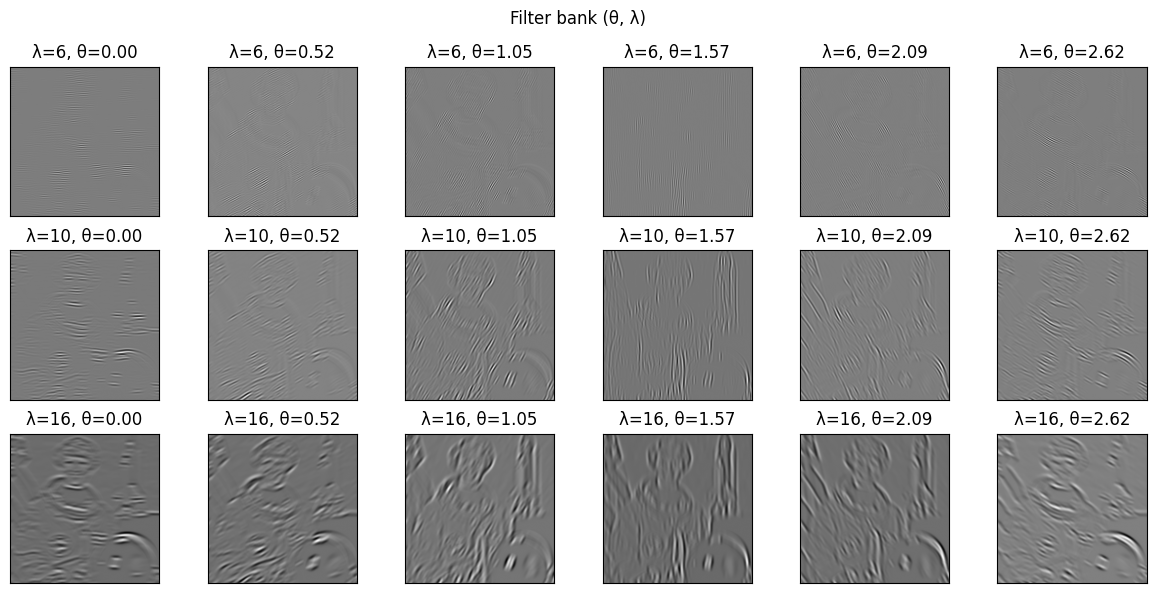

In [5]:
# === Explore θ and λ ===
thetas = np.linspace(0, np.pi, 6, endpoint=False)
lambdas = [6.0, 10.0, 16.0]

fig, axes = plt.subplots(len(lambdas), len(thetas), figsize=(12,6))
for i, lam in enumerate(lambdas):
    for j, th in enumerate(thetas):
        g = gabor_kernel(ksize=31, sigma=6.0, theta=th, lam=lam, gamma=0.5, phi=0.0)
        resp = conv2_same(img_gray, g)
        axes[i, j].imshow(resp, cmap='gray')
        axes[i, j].set_xticks([]); axes[i, j].set_yticks([])
        axes[i, j].set_title(f"λ={lam:.0f}, θ={th:.2f}")
plt.suptitle("Filter bank (θ, λ)")
plt.tight_layout()
plt.show()


## Questions rapides (6 min)
1. Comment évolue la réponse lorsque θ varie ? Identifier les textures orientées (cheveux, tissus, contours...).  

When θ changes, the Gabor filter rotates, so it detects different orientations in the image.
For example, when θ ≈ 0, it reacts to horizontal lines (like mouth or hat edges).
When θ ≈ 1.57 (π/2), it reacts to vertical lines (like hair or face borders).
Intermediate angles detect diagonal textures (fabric folds, corners, etc.).


2. Quel est l’effet de λ (fréquence spatiale) ? Quelles structures sont mieux détectées avec des valeurs petites vs grandes ?  

λ controls the frequency of the sinusoidal pattern inside the filter.

Small λ => high frequency => fine details, small textures, thin lines.

Large λ => low frequency => large structures, smooth contours, wide patterns.

3. Pourquoi normaliser le noyau (moyenne nulle, norme unité) avant convolution ?  

Zero mean => avoids being influenced by overall brightness of the image (ambient light).

Unit norm => keeps responses comparable across orientations and scales.